# 1. Import Libraries

In [19]:
import os
import requests
from io import BytesIO
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 2. Load Dataset

### 2.1 Define GitHub Repo & Folder Path

In [4]:
GITHUB_REPO = "prattapong/Commercial-Airplane-Model-Image-Classification"
GITHUB_FOLDER = "images"
GITHUB_API_URL = f"https://api.github.com/repos/{GITHUB_REPO}/contents/{GITHUB_FOLDER}"

### 2.2 Fetch Image URLs and Load Image

In [ ]:
# Fetch Image URLs Automatically
def get_image_urls():
    response = requests.get(GITHUB_API_URL)
    if response.status_code != 200:
        raise Exception(f"Error fetching images: {response.json()}")

    image_urls = {}
    for folder in response.json():
        if folder["type"] == "dir":  # Ensure it's a folder (A350, B787, A320)
            class_name = folder["name"]
            image_urls[class_name] = []
            folder_url = folder["url"]

            # Fetch image files in each class folder
            folder_response = requests.get(folder_url)
            if folder_response.status_code == 200:
                for file in folder_response.json():
                    if file["name"].lower().endswith((".jpg", ".jpeg", ".png")):
                        image_urls[class_name].append(file["download_url"])

    return image_urls

# Load Images Using Image.open()
def load_images(image_urls):
    IMG_SIZE = (224, 224)  # Resize all images to 224x224
    X, y = [], []

    for label, urls in image_urls.items():
        for url in urls:
            try:
                response = requests.get(url)
                img = Image.open(BytesIO(response.content)).convert("RGB")  # Load image
                img = img.resize(IMG_SIZE)
                X.append(np.array(img) / 255.0)  # Normalize
                y.append(label)
            except Exception as e:
                print(f"Error loading {url}: {e}")

    return np.array(X), pd.Categorical(y).codes

# 3. Data-preprocessing

In [ ]:
def augment_data(X_train):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    datagen.fit(X_train)

    return datagen

# 4. Train model

In [7]:
def train_model(X, y, batch_size:int, epochs:int):
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = 0.2,
        stratify = y,
        random_state = 244
    )

    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    # Add classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(len(set(y)), activation="softmax")(x)  # Output layer for classification

    model = Model(inputs=base_model.input, outputs=x)
    model.build((None, 224, 224, 3))  # Build the model with the input shape
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    datagen = augment_data(X_train)
    checkpoint = ModelCheckpoint('best_airplane_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), validation_data=(X_test, y_test), epochs=epochs, callbacks=[checkpoint])

    best_model = tf.keras.models.load_model('best_airplane_model.h5')
    print("Best model saved as 'best_airplane_model.h5'")

    return best_model

In [8]:
image_urls = get_image_urls()
X, y = load_images(image_urls)
best_model = train_model(
    X = X,
    y = y,
    batch_size = 8,
    epochs = 100
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3923 - loss: 1.2188  
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to best_airplane_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.3897 - loss: 1.2071 - val_accuracy: 0.2500 - val_loss: 1.1622
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3923 - loss: 1.1135
Epoch 2: val_accuracy did not improve from 0.25000
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 0.3897 - loss: 1.1232 - val_accuracy: 0.2500 - val_loss: 1.1041
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3308 - loss: 1.1309
Epoch 3: val_accuracy improved from 0.25000 to 0.50000, saving model to best_airplane_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.3744 - loss: 1.1163 - val_accuracy: 0.5000 - val_loss: 1.0787
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5692 - loss: 1.0825   
Epoch 4: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5590 - loss: 1.0866 - val_accuracy: 0.5000 - val_loss: 1.0785
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5692 - loss: 1.0897
Epoch 5: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.5590 - loss: 1.0882 - val_accuracy: 0.2500 - val_loss: 1.0954
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.3798 - loss: 1.0818
Epoch 6: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3814 - loss: 1.0820 - val_accuracy: 0.2500 - val_loss: 1.1120
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3538 - loss: 1.0845
Epoch 7: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5256 - loss: 1.0562 - val_accuracy: 0.7500 - val_loss: 1.0344
Epoch 42/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.4183 - loss: 1.0998
Epoch 42: val_accuracy did not improve from 0.75000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4327 - loss: 1.0949 - val_accuracy: 0.7500 - val_loss: 1.0296
Epoch 43/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4308 - loss: 1.0637
Epoch 43: val_accuracy did not improve from 0.75000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.4410 - loss: 1.0599 - val_accuracy: 0.7500 - val_loss: 1.0279
Epoch 44/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3692 - loss: 1.0799
Epoch 44: val_accuracy did not improve from 0.75000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.4256 - loss: 1.0710 - val_accuracy: 0.7500 - val_loss: 1.0254
Epoch 45/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3923 - loss: 1.0822
Epoch 45: val_accuracy did not improve from 0.75000
2/2 ━━━━━

Best model saved as 'best_airplane_model.h5'


# 5. Show result of a sample

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def show_prediction(model, X, y, index, class_labels):
    """
    Displays an image from X[index] with the model's predicted and actual label.

    Parameters:
    - model: Trained Keras model
    - X: NumPy array of images
    - y: NumPy array of actual labels
    - index: Index of the image to display
    - class_labels: List of class names corresponding to label indices
    """
    sample_image = np.array(X[index])
    sample_input = np.expand_dims(sample_image, axis=0)

    predicted_class = np.argmax(model.predict(sample_input))
    actual_class = y[index]

    predicted_label = class_labels[predicted_class]
    actual_label = class_labels[actual_class]

    # Display the image with prediction
    plt.imshow(sample_image)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}", fontsize=12, color="blue")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


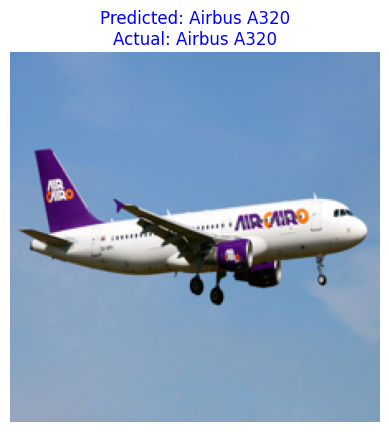

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


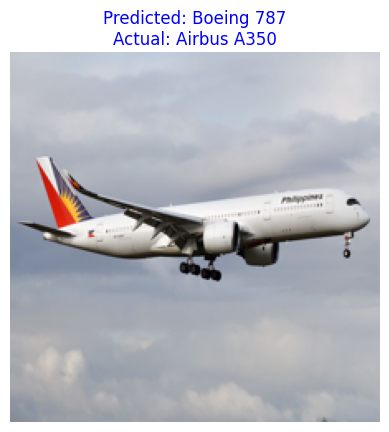

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


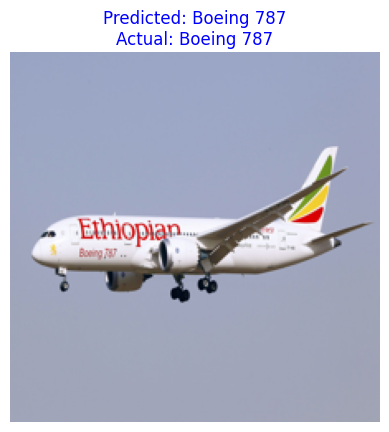

In [30]:
class_labels = ["Airbus A320", "Airbus A350", "Boeing 787"]

for i in [0,7,11]:
    show_prediction(best_model, X, y, index=i, class_labels=class_labels)